**CAR LICENSE PLATE DETECTION - FINAL PROJECT**

**MACHINE LEARING 2 - FALL 2021**

**Introduction:**

License Plate Recognition (LPR) is a problem aimed at identifying vehicles by detecting
and recognizing its license plate. It has been broadly used in real life applications such as traffic
monitoring systems which include unattended parking lots, automatic toll collection, and
criminal pursuit.

The target of this project is to implement a vehicle retrieval system for a Indian
surveillance camera, by detecting and recognizing India license plates. It will be useful for
vehicle registration and identification, and therefore may further contribute to the possibility of
vehicle tracking and vehicle activity analysis.



**Dataset:**

The dataset was download from Kaggle with the link https://www.kaggle.com/andrewmvd/car-plate-detection . This dataset contains 433 images with bounding box annotations of the car license plates within the images. After downloading the dataset, I reduced the size of the dataset by manually deleting images from 433 images to 125 images.





**Preprocessing:**

First, I import the libraries.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, MaxPool2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras import initializers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Input
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions
from keras import backend as K
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

Import data by uploading the zip file and extract all.

In [ ]:
from zipfile import ZipFile
file_name = './data125.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


I create the variable X containing all the images of cars by resizing them to 200 * 200.

In [ ]:
IMAGE_SIZE = 200

In [ ]:
img_dir = "./images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() # Sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

I create the variable y containing all the bounding boxe annotations (label). Before that, I resize the annotations so that it fits the new size of the images (200*200). 

In [ ]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

Create a function resizeannotation.

In [ ]:
path = './annotations'
text_files = ['./annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [ ]:
resizeannotation("./annotations/Cars17.xml")

[175, 153, 153, 140]

In [ ]:
y[0]

[167, 129, 90, 93]

In [ ]:
# Check X shape
np.array(X).shape

(125, 200, 200, 3)

In [ ]:
# Check y shape
np.array(y).shape

(125, 4)

Display the first eighteen images of the dataset.

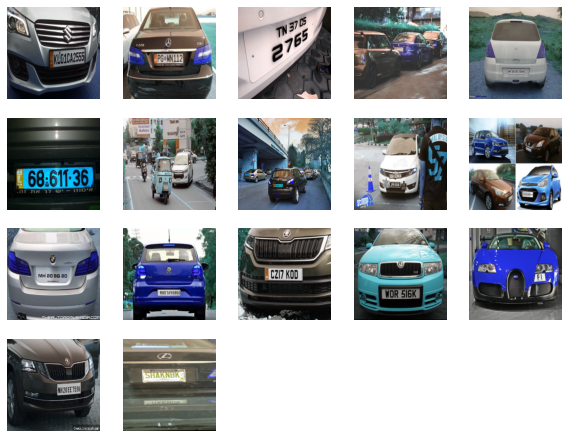

In [ ]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

Draw the rectangle containing the license plate using the OpenCV library.

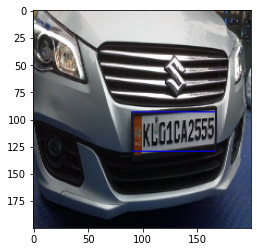

In [ ]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

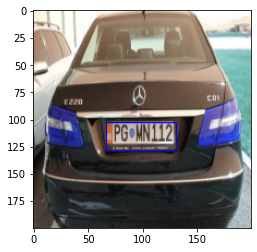

In [ ]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

Prepare the data for the CNN.

In [ ]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [ ]:
#Renormalisation
X = X / 255
y = y / 255

In [ ]:
# Seed for reproducing same results
seed = 42
np.random.seed(seed)

Split the dataset in two: training set/testing set.

In [ ]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

**Application of different types of neural networks**

Regular multilayer fully connected (dense) networks

Convolutional Neural Networks

Model 1: Add many different types of layers.

In [ ]:
#Destroys the current TF graph and creates a new one. Useful to avoid clutter from old models / layers.
from keras import backend as K
K.clear_session()
# create model 1: Regular multilayer fully connected (dense) networks
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), activation='relu'))
model.add(Conv2D(32, (16,16), activation='relu'))
model.add(Conv2D(64, (8,8), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(4, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 179, 179, 16)      23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 164, 164, 32)      131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 157, 157, 64)      131136    
                                                                 
 flatten (Flatten)           (None, 1577536)           0         
                                                                 
 dense (Dense)               (None, 64)                100962368 
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 1

In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100, verbose=1)

# evaluate the keras model
_,accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/20
1/1 [==============================] - 174s 174s/step - loss: 2.4933 - accuracy: 0.2500 - val_loss: 26916.4004 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 174s 174s/step - loss: 27028.7051 - accuracy: 0.0000e+00 - val_loss: 609059.5625 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 176s 176s/step - loss: 595916.5000 - accuracy: 0.0000e+00 - val_loss: 6915469.0000 - val_accuracy: 0.5200
Epoch 4/20
1/1 [==============================] - 174s 174s/step - loss: 6993313.5000 - accuracy: 0.4600 - val_loss: 3776894.0000 - val_accuracy: 0.4800
Epoch 5/20
1/1 [==============================] - 173s 173s/step - loss: 3712038.7500 - accuracy: 0.5400 - val_loss: 22328304.0000 - val_accuracy: 0.5200
Epoch 6/20
1/1 [==============================] - 174s 174s/step - loss: 22405516.0000 - accuracy: 0.4600 - val_loss: 77260752.0000 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 176s 176s/step - loss

Model 2: Try different activation functions, different types of gradient descent.

In [ ]:
#Model 2
#Destroys the current TF graph and creates a new one. Useful to avoid clutter from old models / layers.
from keras import backend as K
K.clear_session()
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (24,24),activation='relu', padding='same'))
model.add(Conv2D(32, (8,8), activation='tanh', padding='same'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(4, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      55328     
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      589856    
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 200, 32)      65568     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dense (Dense)               (None, 64)                20480064  
                                                        

In [ ]:
#Create learning rate schedule
opt_sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)

# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer=opt_sgd, metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=128)
...
# evaluate the keras model
_,accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
1/1 [==============================] - 773s 773s/step - loss: 2.4867 - accuracy: 0.3900
Epoch 2/10
1/1 [==============================] - 760s 760s/step - loss: 2.8654 - accuracy: 0.4600
Epoch 3/10
1/1 [==============================] - 757s 757s/step - loss: 3.1817 - accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 755s 755s/step - loss: 2.5530 - accuracy: 0.4600
Epoch 5/10
1/1 [==============================] - 752s 752s/step - loss: 2.7250 - accuracy: 0.5400
Epoch 6/10
1/1 [==============================] - 758s 758s/step - loss: 2.6161 - accuracy: 0.5400
Epoch 7/10
1/1 [==============================] - 751s 751s/step - loss: 2.5993 - accuracy: 0.5400
Epoch 8/10
1/1 [==============================] - 764s 764s/step - loss: 2.5470 - accuracy: 0.5400
Epoch 9/10
1/1 [==============================] - 742s 742s/step - loss: 2.5726 - accuracy: 0.4600
Epoch 10/10
1/1 [==============================] - 28s 28s/step - loss: 2.6798 - accuracy: 0.5200
Accurac

**Try various network architectures**
depth, stride, zero padding.

Model 3: Tune various batch size, epochs, tune weight initiazation

In [ ]:
#Model 3
#Destroys the current TF graph and creates a new one. Useful to avoid clutter from old models / layers.
from keras import backend as K
K.clear_session()
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (24,24),activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), activation='tanh', padding='same'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='softmax'))
model.add(Dense(64, activation='relu', kernel_regularizer="l2",kernel_initializer=initializers.RandomNormal(mean=0,stddev=0.05773)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      55328     
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      589856    
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 200, 64)      131136    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 64)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 640000)            0         
                                                                 
 dense (Dense)               (None, 64)                40960064  
                                                        

In [ ]:
# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=32)
...
# evaluate the keras model
_,accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
4/4 [==============================] - 828s 182s/step - loss: 2.6216 - accuracy: 0.0300
Epoch 2/10
4/4 [==============================] - 792s 182s/step - loss: 2.6074 - accuracy: 0.0400
Epoch 3/10
4/4 [==============================] - 754s 167s/step - loss: 2.5963 - accuracy: 0.1000
Epoch 4/10
4/4 [==============================] - 739s 164s/step - loss: 2.5858 - accuracy: 0.1400
Epoch 5/10
4/4 [==============================] - 717s 163s/step - loss: 2.5766 - accuracy: 0.2600
Epoch 6/10
4/4 [==============================] - 732s 167s/step - loss: 2.5689 - accuracy: 0.2200
Epoch 7/10
4/4 [==============================] - 714s 161s/step - loss: 2.5618 - accuracy: 0.2500
Epoch 8/10
4/4 [==============================] - 706s 161s/step - loss: 2.5561 - accuracy: 0.3300
Epoch 9/10
4/4 [==============================] - 711s 162s/step - loss: 2.5531 - accuracy: 0.2500
Epoch 10/10
1/1 [==============================] - 30s 30s/step - loss: 2.5886 - accuracy: 0.5200
Accuracy: 5

Model 4: Tune various batch size, epochs, tune weight initiazation.

In [ ]:
#Destroys the current TF graph and creates a new one. Useful to avoid clutter from old models / layers.
from keras import backend as K
K.clear_session()
model = Sequential()
model.add(Conv2D(64, (24,24), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (24,24), kernel_regularizer="l1",activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (8,8), activation='relu', padding='same', strides=2))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      110656    
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      2359360   
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        131104    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 128)               2560128   
                                                        

In [ ]:
# compile the keras model
model.compile(loss='mean_squared_error', optimizer="adam", metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=32)
# evaluate the keras model
_,accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
4/4 [==============================] - 504s 113s/step - loss: 85.0106 - accuracy: 0.4700
Epoch 2/10
4/4 [==============================] - 504s 115s/step - loss: 30.5110 - accuracy: 0.2700
Epoch 3/10
4/4 [==============================] - 502s 113s/step - loss: 20.0153 - accuracy: 0.4000
Epoch 4/10
4/4 [==============================] - 500s 113s/step - loss: 19.2161 - accuracy: 0.4600
Epoch 5/10
4/4 [==============================] - 500s 114s/step - loss: 11.6111 - accuracy: 0.4600
Epoch 6/10
4/4 [==============================] - 495s 112s/step - loss: 10.1020 - accuracy: 0.4600
Epoch 7/10
4/4 [==============================] - 497s 113s/step - loss: 7.7845 - accuracy: 0.5400
Epoch 8/10
4/4 [==============================] - 495s 112s/step - loss: 6.4074 - accuracy: 0.4600
Epoch 9/10
4/4 [==============================] - 496s 113s/step - loss: 5.3983 - accuracy: 0.4600
Epoch 10/10
1/1 [==============================] - 25s 25s/step - loss: 4.3569 - accuracy: 0.5200
Accur

Use Karas tuner

Install and import the Keras Tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
!pip install -q -U keras-tuner
import keras_tuner as kt

In [ ]:
#Destroys the current TF graph and creates a new one. Useful to avoid clutter from old models / layers.
from keras import backend as K
K.clear_session()

In [ ]:
import keras_tuner as kt

Build model

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Flatten())
    model.add(Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))
    model.add(Dense(4, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


build_model(kt.HyperParameters())

Instantiate the tuner and perform hypertuning.

In [ ]:
#Instantiate the tuner to perform the hypertuning
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="finalproject",
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


Create a callback to stop training early after reaching a certain value for the validation loss.

In [ ]:
#Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
#Run the hyperparameter search
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 3 Complete [00h 00m 30s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.5
Total elapsed time: 00h 02m 18s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
## Get the optimal hyperparameters
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('lr')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.00035520766754210267.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 30 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/30
3/3 [==============================] - 3s 415ms/step - loss: 66.3365 - accuracy: 0.2375 - val_loss: 89.2899 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 1s 284ms/step - loss: 77.8226 - accuracy: 0.5250 - val_loss: 74.6847 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 291ms/step - loss: 73.0836 - accuracy: 0.0000e+00 - val_loss: 65.5297 - val_accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 1s 284ms/step - loss: 69.2383 - accuracy: 0.5625 - val_loss: 73.1156 - val_accuracy: 0.5000
Epoch 5/30
3/3 [==============================] - 1s 288ms/step - loss: 64.0897 - accuracy: 0.3875 - val_loss: 57.7589 - val_accuracy: 0.0000e+00
Epoch 6/30
3/3 [==============================] - 1s 281ms/step - loss: 62.5593 - accuracy: 0.0125 - val_loss: 51.0441 - val_accuracy: 0.5000
Epoch 7/30
3/3 [==============================] - 1s 290ms/step - loss: 51.2515 - accuracy: 0.5125 - val_loss: 54.7420 - val_accuracy: 0

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/15
3/3 [==============================] - 2s 364ms/step - loss: 73.2072 - accuracy: 0.4500 - val_loss: 70.2782 - val_accuracy: 0.5000
Epoch 2/15
3/3 [==============================] - 1s 281ms/step - loss: 82.6031 - accuracy: 0.2125 - val_loss: 91.5664 - val_accuracy: 0.5000
Epoch 3/15
3/3 [==============================] - 1s 352ms/step - loss: 86.9740 - accuracy: 0.5375 - val_loss: 74.8027 - val_accuracy: 0.0000e+00
Epoch 4/15
3/3 [==============================] - 1s 441ms/step - loss: 66.8276 - accuracy: 0.0000e+00 - val_loss: 33.5749 - val_accuracy: 0.5000
Epoch 5/15
3/3 [==============================] - 1s 280ms/step - loss: 40.8172 - accuracy: 0.4750 - val_loss: 45.3423 - val_accuracy: 0.5000
Epoch 6/15
3/3 [==============================] - 1s 277ms/step - loss: 46.3496 - accuracy: 0.4875 - val_loss: 31.0693 - val_accuracy: 0.4500
Epoch 7/15
3/3 [==============================] - 1s 280ms/step - loss: 26.5629 - accuracy: 0.5875 - val_loss: 29.2575 - val_accuracy: 0.000

In [ ]:
#Evaluate the hypermodel on the test data
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

1/1 [==============================] - 0s 100ms/step - loss: 11.3768 - accuracy: 0.5200
[test loss, test accuracy]: [11.37680435180664, 0.5199999809265137]


**Transfer learning - pre-trained CNN**

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. We either use the pretrained model as is or use transfer learning to customize this model to a given task.

These transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

Use REsNet50 pre-trained model

ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. It has 3.8 x 10^9 Floating points operations. It is a widely used ResNet model and we have explored ResNet50 architecture in depth.

*ResNet50* 

In [ ]:
# Use REsNet50 for classification RESNET
K.clear_session()
model = Sequential()
model.add(ResNet50(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=62, verbose=1)
# evaluate the keras model
_,accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/20
2/2 [==============================] - 23s 10s/step - loss: 0.0819 - accuracy: 0.4900 - val_loss: 0.2179 - val_accuracy: 0.4800
Epoch 2/20
2/2 [==============================] - 17s 8s/step - loss: 0.2169 - accuracy: 0.5400 - val_loss: 0.2182 - val_accuracy: 0.4800
Epoch 3/20
2/2 [==============================] - 16s 8s/step - loss: 0.2132 - accuracy: 0.5400 - val_loss: 0.1857 - val_accuracy: 0.4800
Epoch 4/20
2/2 [==============================] - 16s 8s/step - loss: 0.1941 - accuracy: 0.5400 - val_loss: 0.1908 - val_accuracy: 0.4800
Epoch 5/20
2/2 [==============================] - 17s 8s/step - loss: 0.1876 - accuracy: 0.5400 - val_loss: 0.1545 - val_accuracy: 0.4800
Epoch 6/20
2/2 [==============================] - 17s 8s/step - loss: 0.1822 - accuracy: 0.5400 - val_loss: 0.2190 - val_accuracy: 0.4800
Epoch 7/20
2/2 [==============================] - 16s 8s/step - loss: 0.2177 - accuracy: 0.5400 - val_loss: 0.2190 - val_accuracy: 0.4800
Epoch 8/20
2/2 [=================

*Using VGG19 pre-trained model*

VGG19 is a variant of VGG model which in short consists of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer). There are other variants of VGG like VGG11, VGG16 and others. VGG19 has 19.6 billion FLOPs.

In [ ]:
# Create the model VGG19
# Destroys the current TF graph and creates a new one. Useful to avoid clutter from old models / layers.
K.clear_session()
model = Sequential()
model.add(VGG19(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)
_,accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/20
4/4 [==============================] - 65s 15s/step - loss: 0.0437 - accuracy: 0.4900 - val_loss: 0.0556 - val_accuracy: 0.4000
Epoch 2/20
4/4 [==============================] - 61s 15s/step - loss: 0.0430 - accuracy: 0.6300 - val_loss: 0.0349 - val_accuracy: 0.3200
Epoch 3/20
4/4 [==============================] - 61s 15s/step - loss: 0.0248 - accuracy: 0.4000 - val_loss: 0.0205 - val_accuracy: 0.4400
Epoch 4/20
4/4 [==============================] - 61s 15s/step - loss: 0.0162 - accuracy: 0.7800 - val_loss: 0.0202 - val_accuracy: 0.3600
Epoch 5/20
4/4 [==============================] - 61s 15s/step - loss: 0.0125 - accuracy: 0.5900 - val_loss: 0.0197 - val_accuracy: 0.5200
Epoch 6/20
4/4 [==============================] - 72s 19s/step - loss: 0.0126 - accuracy: 0.7100 - val_loss: 0.0116 - val_accuracy: 0.6400
Epoch 7/20
4/4 [==============================] - 69s 17s/step - loss: 0.0099 - accuracy: 0.6400 - val_loss: 0.0121 - val_accuracy: 0.4800
Epoch 8/20
4/4 [===========

*Using VGG16 pre-trained model*

VGG-16 is a convolutional neural network that is 16 layers deep. We can load a pretrained version of the network trained on more than a million images from the ImageNet database [1]. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [ ]:
# Create the model VGG16
# Destroys the current TF graph and creates a new one. Useful to avoid clutter from old models / layers.
from keras import backend as K
K.clear_session()
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17,099,140
Trainable params: 2,384,452
Non

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=20, verbose=1)
# evaluate the keras model
_,accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/30
5/5 [==============================] - 51s 11s/step - loss: 0.0741 - accuracy: 0.3100 - val_loss: 0.0330 - val_accuracy: 0.4800
Epoch 2/30
5/5 [==============================] - 50s 11s/step - loss: 0.0265 - accuracy: 0.2700 - val_loss: 0.0187 - val_accuracy: 0.5600
Epoch 3/30
5/5 [==============================] - 51s 11s/step - loss: 0.0170 - accuracy: 0.4600 - val_loss: 0.0170 - val_accuracy: 0.6400
Epoch 4/30
5/5 [==============================] - 50s 10s/step - loss: 0.0108 - accuracy: 0.6600 - val_loss: 0.0125 - val_accuracy: 0.8000
Epoch 5/30
5/5 [==============================] - 50s 10s/step - loss: 0.0067 - accuracy: 0.6500 - val_loss: 0.0097 - val_accuracy: 0.7200
Epoch 6/30
5/5 [==============================] - 50s 11s/step - loss: 0.0043 - accuracy: 0.8200 - val_loss: 0.0100 - val_accuracy: 0.5200
Epoch 7/30
5/5 [==============================] - 49s 10s/step - loss: 0.0029 - accuracy: 0.7500 - val_loss: 0.0087 - val_accuracy: 0.6000
Epoch 8/30
5/5 [===========

Show plot

In [ ]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

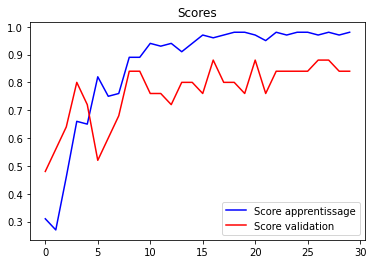

In [ ]:
plot_scores(train)

Detection

In [ ]:
 y_cnn = model.predict(X_test)
 y_cnn.shape

(25, 4)

See how our model localize license plates on our testing set:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

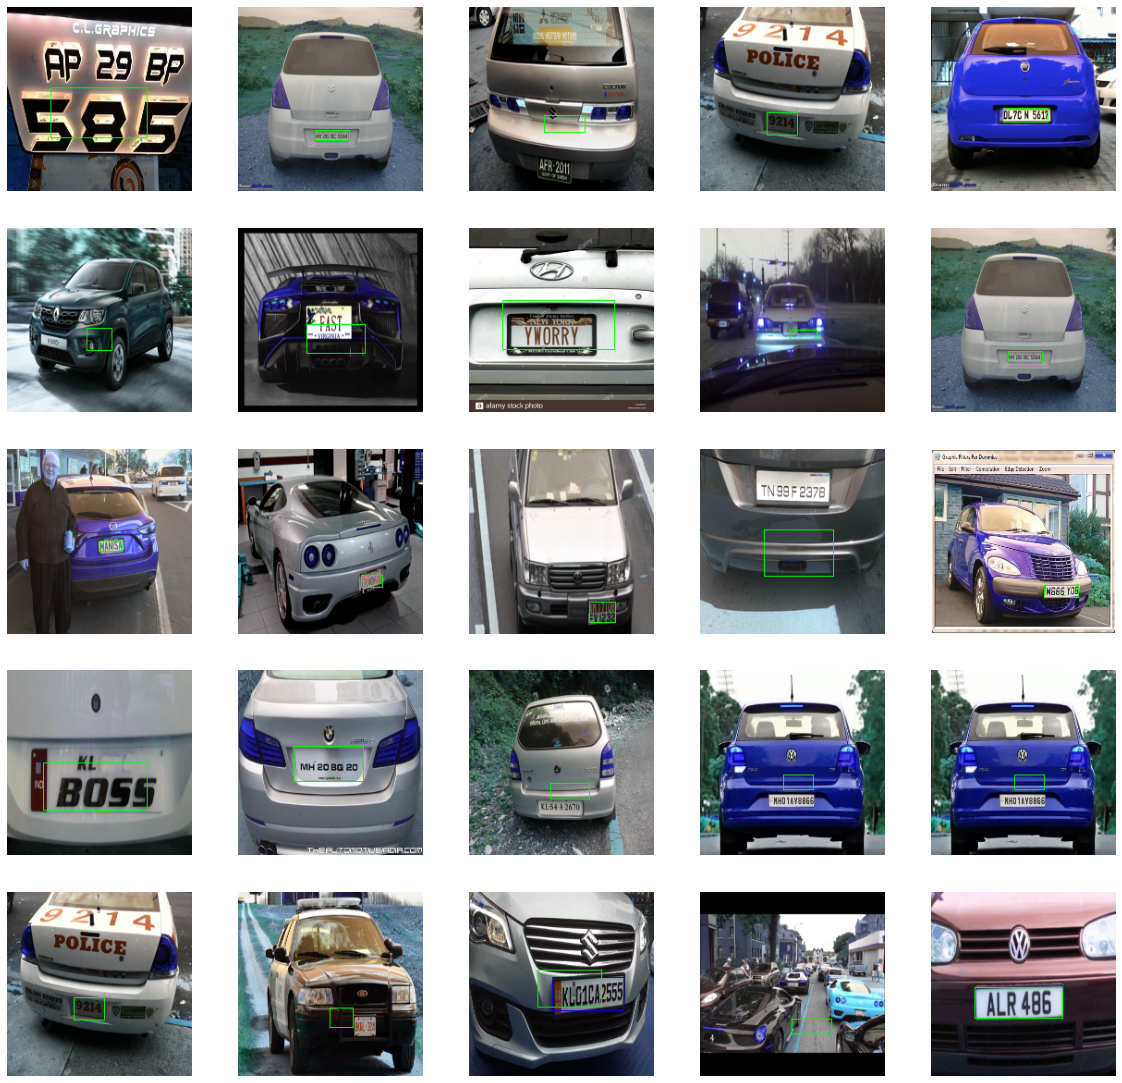

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

**Results and Discussion:**

After trying many types of neural networks, changing various hyperparameters - batch size, epochs, learning, using learning rate schedule, tune weight initialization, defferent types of gradient descent, defferent activation functions, different cost functions, using of karas tuner, the accuracy score built from scratch was not good comparing with using pre-trained CNNs. I tried three pre-trained models (Resnet50, VGG16, VGG19), the VGG16 showed the best accuracy score.

The framework of this implementation is flexible to re-configure into other real-life applications. And the recognition rate is 84% based on a 100 testing images trial. However, the model defined above is a very simple toy model. The training is straightforward and tests may not be reliable since the dataset is so small. However, it proves a concept that we can find plates from images with a simple CNN. This network may be used as a part of other more complicated networks.